# K-means segmentation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import pandas as pd

from pyspark.ml.clustering import KMeans
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler

import helper as h

In [2]:
_data = h.get_merged_data('k-means', year='2016')

_data.head()

% of users dropped 4.698526359485271


Row(login='0loky0', followers_count=0, following_count=1, blog=0, company=0, created_at=datetime.datetime(2011, 5, 24, 16, 15, 25), public_repos_count=7, public_gists_count=0, hireable=1, recency=1788, updated_at=datetime.datetime(2019, 1, 9, 10, 3, 59), time_between_first_last_event=11, last_event=datetime.datetime(2016, 4, 15, 6, 14, 3), first_event=datetime.datetime(2016, 4, 4, 14, 44, 57), frequency=19, second_period_event_count=0, CommitCommentEvent_count=0, CreateEvent_count=5, DeleteEvent_count=0, ForkEvent_count=2, GollumEvent_count=0, IssueCommentEvent_count=0, IssuesEvent_count=0, MemberEvent_count=0, PublicEvent_count=0, PullRequestEvent_count=0, PullRequestReviewCommentEvent_count=0, PushEvent_count=12, ReleaseEvent_count=0, WatchEvent_count=0)

In [3]:
churn_data = _data.filter(_data.company == 0) 

## Create new features

1. Active events.
2. Public repos and gists

Take the log of each of these.

In [4]:
churn_data = h.feature_scaling(churn_data)
churn_data = h.create_KMeans_features(churn_data, False)

In [5]:
churn_data.select(['frequency', 'recency']).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
frequency,152882,2.301765602838608,1.0683421846615078,1.0986122886681098,5.298317366548036
recency,152882,4.508259232929171,2.7240966142877676,0.0,8.01829613851552


In [6]:
churn_data.head()

Row(login='0loky0', followers_count=0.0, following_count=0.6931471805599453, blog=0, company=0, created_at=datetime.datetime(2011, 5, 24, 16, 15, 25), public_repos_count=2.0794415416798357, public_gists_count=0.0, hireable=1, recency=7.489412083508719, updated_at=datetime.datetime(2019, 1, 9, 10, 3, 59), time_between_first_last_event=11, last_event=datetime.datetime(2016, 4, 15, 6, 14, 3), first_event=datetime.datetime(2016, 4, 4, 14, 44, 57), frequency=2.995732273553991, second_period_event_count=0, CommitCommentEvent_count=0.0, CreateEvent_count=1.791759469228055, DeleteEvent_count=0.0, ForkEvent_count=1.0986122886681098, GollumEvent_count=0.0, IssueCommentEvent_count=0.0, IssuesEvent_count=0.0, MemberEvent_count=0.0, PublicEvent_count=0.0, PullRequestEvent_count=0.0, PullRequestReviewCommentEvent_count=0.0, PushEvent_count=2.5649493574615367, ReleaseEvent_count=0.0, WatchEvent_count=0.0, KMeans_features=DenseVector([2.9957, 7.4894]))

In [7]:
# Trains a k-means model.
kmeans = KMeans(featuresCol='KMeans_features', 
                predictionCol='high_low_user').setK(2).setSeed(1)
model = kmeans.fit(churn_data)

# Evaluate clustering by computing Within Set Sum of Squared Errors.
wssse = model.computeCost(churn_data)
print("Within Set Sum of Squared Errors = " + str(wssse))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Within Set Sum of Squared Errors = 332152.1339521521
Cluster Centers: 
[1.6446129  0.73230997]
[2.58760029 6.15064353]


In [8]:
model.write().overwrite().save('KMeans_model')

In [9]:
predictions = model.transform(churn_data)

In [10]:
predictions_df = predictions.toPandas()

In [11]:
centers[0][0]

1.6446128973193355

/home/brian/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


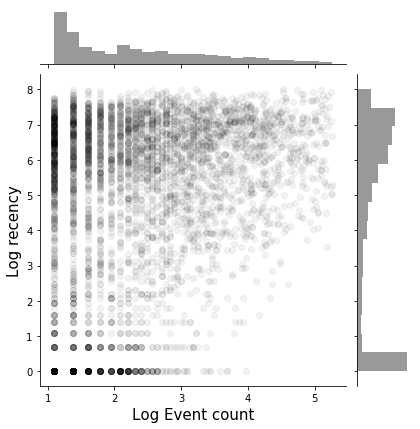

In [12]:
import seaborn as sns

nusers=5000

low = predictions_df[:nusers]#[predictions_df[:nusers].high_low_user.values == 0]

g = sns.jointplot(x="frequency", y="recency", data=low, alpha=0.05, color='k')
g.set_axis_labels('Log Event count', 'Log recency', fontsize=15)

g.savefig('figures/Kmeans_clustering.png', dpi=300)

/home/brian/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


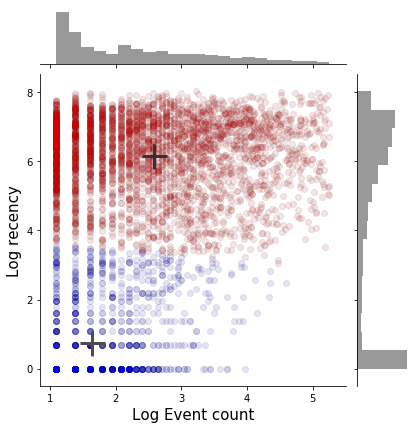

In [13]:
import seaborn as sns

nusers=5000

all = predictions_df[:nusers]
low = predictions_df[:nusers][predictions_df[:nusers].high_low_user.values == 0]
high = predictions_df[:nusers][predictions_df[:nusers].high_low_user.values == 1]

g = sns.jointplot(x="frequency", y="recency", data=all, alpha=0.05, color='k')
g.ax_joint.scatter(low.frequency, low.recency, alpha=0.05, color='b')
g.ax_joint.scatter(high.frequency, high.recency, alpha=0.05, color='r')

g.ax_joint.plot(centers[0][0], centers[0][1], '+', color=[0.3, 0.3, 0.3], ms=25, mew=3)
g.ax_joint.plot(centers[1][0], centers[1][1], '+', color=[0.2, 0.2, 0.2], ms=25, mew=3)

g.set_axis_labels('Log Event count', 'Log recency', fontsize=15)

g.savefig('figures/Kmeans_clustering_wGroups.png', dpi=300)

In [14]:
print('{0}% labels == 0'.format(np.round(np.sum(
    predictions_df.high_low_user == 0) / len(predictions_df.high_low_user) * 100, 2)))

30.31% labels == 0
